# Backtesting with Zipline - Using the Pipeline API with ML-driven Signals

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

## Imports & Settings

In [1]:
!conda install -y -c quantopian ta-lib
!pip install pyfolio
# https://github.com/stefan-jansen/zipline-reloaded
!pip install zipline-reloaded
!pip install Logbook
!pip install ipython-autotime

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

     |████████████████████████████████| 91 kB 5.5 MB/s eta 0:00:011
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88667 sha256=90a5a58dc5d6bc5a089303fde4782a624e592b873468962ba5e377273635a88a
  Stored in directory: /home/jupyter/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
Successfully built pyfolio
     |████████████████████████████████| 6.0 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 5.8 MB/s  eta 0:00:01
     |████████████████████████████████| 159 kB 59.0 MB/s eta 0:00:01
     |████████████████████████████████| 471 kB 45.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 43.7 M

In [2]:
### set path
import os
from pathlib import Path

path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'
path_prediction = path_home / 'prediction'
if not path_prediction.exists():
    path_prediction.mkdir()

'/home/jupyter/random_forests'

In [3]:
import os, sys

zipline_root = path_home / 'zipline'
os.environ['ZIPLINE_ROOT'] = str(zipline_root)
sys.path.append(zipline_root.expanduser().as_posix())

custom_data_path = zipline_root / 'custom_data'
if not custom_data_path.exists():
    custom_data_path.mkdir()

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
%load_ext autotime

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         get_open_orders, cancel_order,
                         order_target, order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import JP_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

time: 1.73 s (started: 2021-04-28 05:29:15 +00:00)


In [7]:
!gsutil cp gs://finance_data_bucket/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

Copying gs://finance_data_bucket/data_stooq.zip...
/ [1 files][651.8 MiB/651.8 MiB]                                                
Operation completed over 1 objects/651.8 MiB.                                    
Archive:  data_stooq.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
  inflating: data/stooq_us_nasdaq_etfs_prices.csv  
  inflating: data/stooq_us_nasdaq_etfs_tickers.csv  
  inflating: data/stooq_us_nasdaq_stocks_prices.csv  
  inflating: data/stooq_us_nasdaq_stocks_tickers.csv  
  inflating: data/stooq_us_nyse_etfs_prices.csv  
  inflating: data/stooq_us_nyse_etfs_tickers.csv  
  inflating: data/stooq_us_nyse_stocks_prices.csv  
  inflating: data/stooq_us_nyse_stocks_tickers.csv  
  inflating: data/stooq_us_nysemkt_stocks_prices.csv  
  inflating: data/stooq_us_nysemkt_stocks_tickers.csv  
  inflating: data/stooq_japan_equities.csv  
time: 35.3 s (started: 2021-04-27 04:29:45 +00:00)


In [ ]:
!ln -s ../../data/stooq_jp_tse_stocks_prices.csv zipline/custom_data/.
!ln -s ../../data/stooq_jp_tse_stocks_tickers.csv zipline/custom_data/.

### Load zipline extensions

Only need this in notebook to find bundle.

In [6]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

time: 50.1 ms (started: 2021-04-28 05:30:12 +00:00)


In [7]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

time: 690 µs (started: 2021-04-28 05:30:14 +00:00)


## Algo Params

The strategy will hold the 25 stocks with the highest positive and lowest negative predictions each as long as there are at least 15 on each side.

In [8]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

time: 599 µs (started: 2021-04-28 05:30:17 +00:00)


## Load Data

In [26]:
import importlib
importlib.reload(stooq_preprocessing)

<module 'stooq_preprocessing' from '/home/jupyter/random_forests/zipline/stooq_preprocessing.py'>

time: 5.17 ms (started: 2021-04-28 07:33:55 +00:00)


In [48]:
import stooq_preprocessing
stooq_preprocessing.load('2017', '2019')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2317013 entries, ('1301.JP', Timestamp('2017-01-04 00:00:00+0000', tz='UTC')) to ('9997.JP', Timestamp('2019-12-30 00:00:00+0000', tz='UTC'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2317013 non-null  float64
 1   high    2317013 non-null  float64
 2   low     2317013 non-null  float64
 3   close   2317013 non-null  float64
 4   volume  2317013 non-null  float64
dtypes: float64(5)
memory usage: 97.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3161 entries, 0 to 3160
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sid     3161 non-null   int64 
 1   ticker  3161 non-null   object
 2   name    3161 non-null   object
dtypes: int64(1), object(2)
memory usage: 74.2+ KB
None
time: 22.5 s (started: 2021-04-28 09:35:31 +00:00)


In [49]:
!zipline ingest -b stooq

[2021-04-28 09:35:55.887209] INFO: zipline.data.bundles.core: Ingesting stooq.
Merging daily equity files:  [####################################]      
time: 46min 14s (started: 2021-04-28 09:35:53 +00:00)


In [50]:
bundle_data = bundles.load('stooq')

time: 43.6 ms (started: 2021-04-28 10:22:08 +00:00)


### ML Predictions

We generate the `train` predictions in the notebook `alphalens_signal_quality` and the `test` predictions in the notebook `random_forest_return_signals`.

In [23]:
#!gsutil cp gs://finance_data_bucket/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

Archive:  stooq_jp_result.zip
  inflating: result/lin_reg_performance.csv  
  inflating: result/tuning_stooq_jp_rf_1.pickle  
  inflating: result/tuning_stooq_jp_rf_5.pickle  
  inflating: result/tuning_stooq_jp_rf_10.pickle  
time: 419 ms (started: 2021-04-27 06:19:49 +00:00)


In [51]:
def load_predictions(bundle):
    t = 1
    #df = pd.concat([pd.read_hdf(results_path / 'predictions.h5', 'train/{:02}'.format(t)),
    #                pd.read_hdf(results_path / 'predictions.h5', 'test/{:02}'.format(t))])
    df = (pd.read_csv(path_result / f'test_{t:02}.csv', parse_dates=['date'])
            .set_index(['ticker','date'])
            .sort_index(level=['ticker','date'])      
         )
    df = df[~df.index.duplicated()].drop('y_test', axis=1)
    predictions = df.iloc[:, :5].mean(1).to_frame('predictions')

    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predictions
            .tz_localize('UTC')), assets

time: 1.25 ms (started: 2021-04-28 10:23:32 +00:00)


In [52]:
predictions, assets = load_predictions(bundle_data)

time: 3.33 s (started: 2021-04-28 10:23:34 +00:00)


In [53]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-12-14 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1 to 3154
dtypes: float64(941)
memory usage: 1.8 MB
time: 48.7 ms (started: 2021-04-28 10:23:42 +00:00)


### Define Custom Dataset

In [54]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = JP_EQUITIES

time: 770 µs (started: 2021-04-28 10:23:58 +00:00)


### Define Pipeline Loaders

In [55]:
signal_loader = {SignalData.predictions:
                 DataFrameLoader(SignalData.predictions, predictions)}

time: 5.09 ms (started: 2021-04-28 10:23:59 +00:00)


## Pipeline Setup

### Custom ML Factor

In [56]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

time: 763 µs (started: 2021-04-28 10:24:02 +00:00)


### Create Pipeline

In [57]:
def compute_signals():
    signals = MLSignal()
    predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs': signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
        screen=StaticAssets(assets)
    )

time: 645 µs (started: 2021-04-28 10:24:04 +00:00)


## Initialize Algorithm

In [58]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.05, min_trade_cost=1))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

time: 735 µs (started: 2021-04-28 10:24:06 +00:00)


### Get daily Pipeline results

In [59]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

time: 720 µs (started: 2021-04-28 10:24:07 +00:00)


## Define Rebalancing Logic

In [60]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)

    positions = context.portfolio.positions
    s = (pd.Series({s: v.amount*v.last_sale_price for s,
                    v in positions.items()})
         .sort_values(ascending=False))
    
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)

    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

time: 2.45 ms (started: 2021-04-28 10:24:11 +00:00)


## Record Data Points

In [61]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

time: 524 µs (started: 2021-04-28 10:24:14 +00:00)


## Run Algorithm

In [62]:
dates = predictions.index.get_level_values('date')
start_date = dates.min() + pd.DateOffset(day=1)
end_date = dates.max()

time: 1.21 ms (started: 2021-04-28 10:24:15 +00:00)


In [63]:
print('Start:\t{}\nEnd:\t{}'.format(start_date.date(), end_date.date()))

Start:	2018-12-01
End:	2019-12-27
time: 549 µs (started: 2021-04-28 10:24:18 +00:00)


In [47]:
# test
import trading_calendars as tc
#tc.get_calendar_names()
xtks = tc.get_calendar('XTKS')
xtks.next_open(pd.Timestamp("2020-01-01"))

Timestamp('2020-01-06 00:01:00+0000', tz='UTC')

time: 4.52 ms (started: 2021-04-28 09:32:45 +00:00)


In [64]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='stooq',
                        custom_loader=signal_loader)# need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2021-04-28 10:25:08.102425]: INFO: handle_simulation_end: Simulated 269 trading days
first open: 2018-12-03 14:31:00+00:00
last close: 2019-12-27 21:00:00+00:00


Duration: 19.16s
time: 19.2 s (started: 2021-04-28 10:24:48 +00:00)


## PyFolio Analysis

In [65]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

time: 560 ms (started: 2021-04-28 10:25:15 +00:00)


In [66]:
benchmark = web.DataReader('NIKKEI225', 
                           'fred', 
                           start='2015', 
                           end='2020').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

time: 3.75 s (started: 2021-04-28 10:25:17 +00:00)


### Custom Plots

IndexError: index -1 is out of bounds for axis 0 with size 0

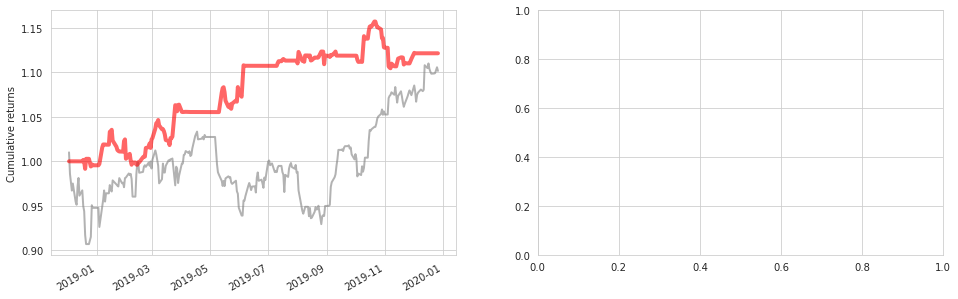

time: 454 ms (started: 2021-04-28 10:26:52 +00:00)


In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2018-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig((path_result / 'pyfolio_out_of_sample').as_posix(), dpi=300);

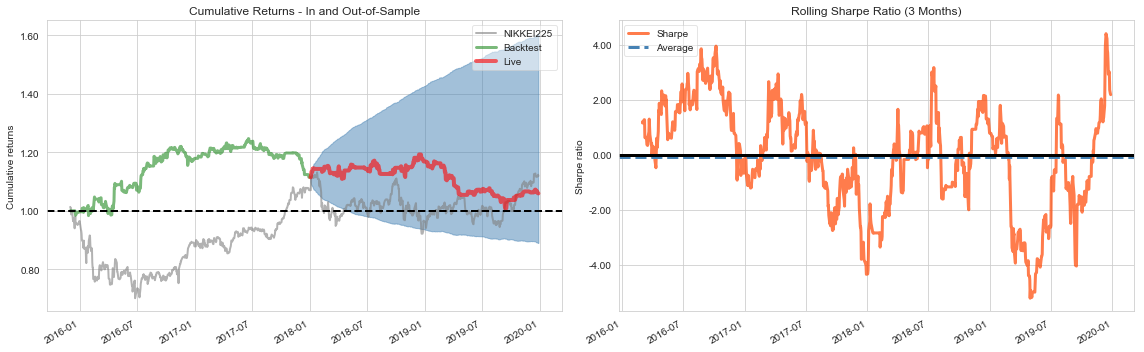

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2018-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig((results_path / 'pyfolio_out_of_sample').as_posix(), dpi=300);

### Tear Sheets

In [69]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2018-01-01', 
                          round_trips=True)

IndexError: single positional indexer is out-of-bounds

time: 153 ms (started: 2021-04-28 10:28:12 +00:00)
